### Get Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams['figure.dpi'] = 150
housing = pd.read_csv('housing.csv')

# Sampling 

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
housing['income_cat'] = pd.cut( housing['median_income'],  
                              bins = [ 0, 1.5, 3.0, 4.5, 6.0, np.inf],
                              labels = [1, 2, 3, 4, 5])
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in  split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
print((housing['income_cat'].value_counts() / len(housing))*100)
print((strat_test_set['income_cat'].value_counts() / len(strat_test_set) )*100)

3    35.058140
2    31.884690
4    17.630814
5    11.443798
1     3.982558
Name: income_cat, dtype: float64
3    35.053295
2    31.879845
4    17.635659
5    11.458333
1     3.972868
Name: income_cat, dtype: float64


In [4]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)
    

In [5]:
housing = strat_train_set.copy()

#### Explore Data

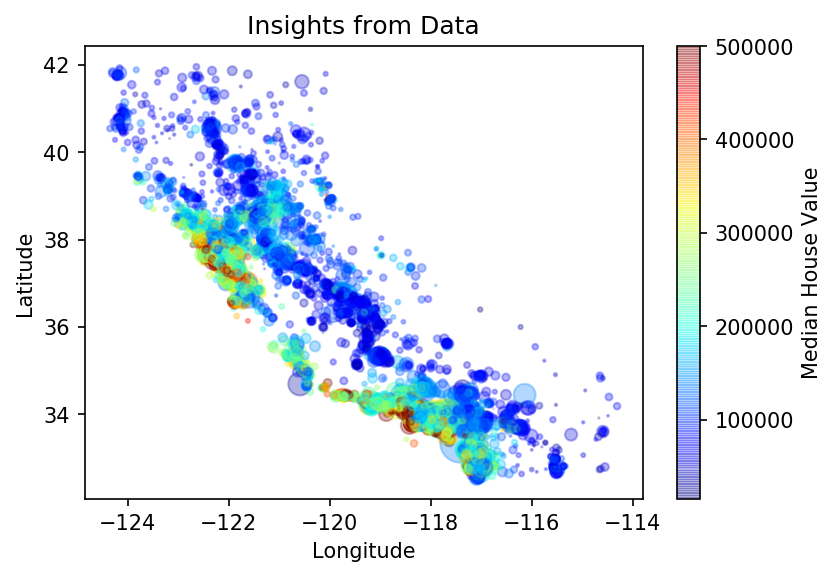

In [6]:
plt.scatter('longitude', 'latitude', data=housing,
           alpha=0.3, c='median_house_value', cmap='jet',
           s=housing["population"]/100)
plt.colorbar(label='Median House Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Insights from Data")
plt.show()

In [7]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

### Data Preprocessing

In [8]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [9]:
housing_num = housing.drop('ocean_proximity', axis=1) # numerical 
housing_cat = housing[ [ 'ocean_proximity'] ] # categorical 

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix ] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [11]:
num_pipeline = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='median')),
        ('attributes_adder', CombinedAttributeAdder()),
        ('std_scaler', StandardScaler()),
    ]
)

In [12]:
from sklearn.compose import ColumnTransformer

In [13]:
num_attribs = list(housing_num.columns)
num_attribs.remove('median_house_value')
cat_attribs = ["ocean_proximity"]

In [14]:
housing_labels = housing['median_house_value']
housing_features = housing.drop('median_house_value', axis=1)

In [15]:
full_pipeline =  ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

# ("drop", "drop", ['a', 'b', 'c', 'd'])

In [16]:
housing_tr = full_pipeline.fit_transform(housing_features)
housing_prepared = pd.DataFrame(housing_tr, columns=[*num_attribs,
                                        "rooms_per_household", "population_per_household", "bedrooms_per_room",
                                        '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'])
housing_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928,1.0,0.0,0.0,0.0,0.0


In [17]:
housing_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

    Linear Regression

    Polynomical Regression

    DecisionTreeRegressor

    RandomForesetRegressor

    SVMRegression

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
lin_reg = LinearRegression()

In [20]:
lin_reg.fit(housing_prepared, housing_labels)
# learning or fitting

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
some_data = housing.iloc[:5]

In [22]:
some_features = some_data.drop('median_house_value', axis=1)
some_labels = some_data['median_house_value']

In [23]:
some_data_prepared = full_pipeline.transform(some_features)

In [24]:
print("Acutal Values")
print(*some_labels, sep='\n')

Acutal Values
286600.0
340600.0
196900.0
46300.0
254500.0


In [25]:
print("Predicted Values")
print(*lin_reg.predict(some_data_prepared), sep='\n')

Predicted Values
210644.60459285552
317768.80697210814
210956.43331178243
59218.988868490735
189747.55849878537


In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
housing_predictions = lin_reg.predict(housing_prepared)

In [28]:
housing_predictions[:5]

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

In [29]:
housing_labels.to_numpy()[:5]

array([286600., 340600., 196900.,  46300., 254500.])

In [30]:
print("RMSE Error: ", np.sqrt(mean_squared_error(housing_labels, housing_predictions)))

RMSE Error:  68628.19819848923


In [31]:
housing['median_house_value'].describe()

count     16512.000000
mean     206990.920724
std      115703.014830
min       14999.000000
25%      119800.000000
50%      179500.000000
75%      263900.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [32]:
from sklearn.tree import DecisionTreeRegressor

In [33]:
tree_reg = DecisionTreeRegressor()

In [34]:
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [35]:
y_hat = tree_reg.predict(housing_prepared)

In [36]:
y_actual = housing_labels

In [37]:
y_hat[:5]

array([286600., 340600., 196900.,  46300., 254500.])

In [38]:
y_actual[:5].to_numpy()

array([286600., 340600., 196900.,  46300., 254500.])

In [39]:
tree_mse = mean_squared_error(y_actual, y_hat)
tree_rmse = np.sqrt(tree_mse)
print("Error: ", tree_rmse)

Error:  0.0


In [40]:
def cross_val_score(model, features, labels, error_matric, cv=10):
    features = housing_prepared.to_numpy()
    labels = labels.to_numpy()
    folds = []
    scores = []
    inds = np.linspace(0, len(features), cv).astype(int)
    for i in range(8):
        j = inds[i+1]
        folds.append((features[i:j], labels[i:j]))
    for i in range(len(folds)):
        test_X = folds[i][0]
        test_Y = folds[i][1]
        train_X = np.concatenate([ folds[j][0] for j in range(len(folds)) if j!=i] )
        train_Y = np.concatenate([ folds[j][1] for j in range(len(folds)) if j!=i] )
        model.fit(train_X, train_Y)
        y_hat = model.predict(test_X)
        scores.append(error_matric(test_Y, y_hat))
    return np.array(scores)
    

In [41]:
def error_matric(y_actual, y_hat):
    return np.sqrt(mean_squared_error(y_actual, y_hat))
cross_val_score(lin_reg, housing_prepared, housing_labels, error_matric, cv=15)

array([68568.22890438, 66850.88689388, 67050.89073931, 66872.61399749,
       68071.04190287, 68794.52914427, 68577.38983074, 68988.2204314 ])

In [42]:
from sklearn.model_selection import cross_val_score

In [43]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error",
                        cv=10)

In [44]:
tree_rmse_scores = np.sqrt(-scores)

In [45]:
tree_rmse_scores

array([69320.37019788, 66654.79770749, 71067.05469506, 68913.55579576,
       71695.2451426 , 74040.97571179, 71169.67932282, 69911.11716322,
       77556.55670146, 69620.94551348])

In [46]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Std: ", scores.std())

In [47]:
np.mean(tree_rmse_scores)

70995.02979515644

In [48]:
display_scores(tree_rmse_scores)

Scores:  [69320.37019788 66654.79770749 71067.05469506 68913.55579576
 71695.2451426  74040.97571179 71169.67932282 69911.11716322
 77556.55670146 69620.94551348]
Mean:  70995.02979515644
Std:  2861.7306128331757


In [50]:
from sklearn.ensemble import RandomForestRegressor

In [51]:
forest_reg = RandomForestRegressor()

In [52]:
forest_reg.fit(housing_prepared, housing_labels)
y_hat = forest_reg.predict(housing_prepared)
print("Error: ", np.sqrt(mean_squared_error(y_actual, y_hat)))

Error:  18735.43037161403


In [53]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error",
                        cv=10)
scores = np.sqrt(-scores)
display_scores(scores)

Scores:  [49453.00268533 47652.16063042 50043.92752053 51943.16370411
 49757.98665951 53403.16398727 49249.69642386 48511.19493469
 52594.88430399 50184.87441624]
Mean:  50279.405526593706
Std:  1731.9321797824837


In [54]:
import joblib 

In [56]:
joblib.dump(lin_reg, "housing_lin_reg.pkl") # model + parameters
joblib.dump(tree_reg, "housing_tree_reg.pkl")
joblib.dump(forest_reg, "housing_forest_reg.pkl")


# maybe later on deploy time

#model_loaded = joblib.load('modelname')

['housing_forest_reg.pkl']

In [57]:
from sklearn.model_selection import GridSearchCV

In [58]:
param_grid = [
    { 'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [ 3, 10], 'max_features': [2, 3, 4]}
]

In [59]:
forest_reg = RandomForestRegressor()

In [60]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error',
                          return_train_score=True)

In [61]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

    3 * 4

    3, 2 -> m1
    3, 4 -> m2
    3, 6 -> m3
    3, 8 -> m4

    10, 2 -> m5
    10, 4 -> m6
    10, 6 -> m7
    10, 8 -> m8


    30, 2 -> m9
    30, 4 -> m10
    30, 6 -> m11
    30, 8 -> m12


    18 models 

In [62]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [63]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [64]:
np.sqrt((-grid_search.best_score_))

49831.61693110528

In [65]:
cvres = grid_search.cv_results_

for i, (mean_score, params) in enumerate(zip(cvres['mean_test_score'], cvres['params'])):
    print(i+1, ".".ljust(5), np.sqrt(-mean_score),"\t", params)

1 .     64014.384917307 	 {'max_features': 2, 'n_estimators': 3}
2 .     55330.48393557641 	 {'max_features': 2, 'n_estimators': 10}
3 .     52369.12636730395 	 {'max_features': 2, 'n_estimators': 30}
4 .     59881.452843504754 	 {'max_features': 4, 'n_estimators': 3}
5 .     52403.14748193717 	 {'max_features': 4, 'n_estimators': 10}
6 .     50392.059116101096 	 {'max_features': 4, 'n_estimators': 30}
7 .     59460.25687948009 	 {'max_features': 6, 'n_estimators': 3}
8 .     52214.55698988898 	 {'max_features': 6, 'n_estimators': 10}
9 .     49831.61693110528 	 {'max_features': 6, 'n_estimators': 30}
10 .     58453.301731514824 	 {'max_features': 8, 'n_estimators': 3}
11 .     52611.39979832672 	 {'max_features': 8, 'n_estimators': 10}
12 .     50006.640892140946 	 {'max_features': 8, 'n_estimators': 30}
13 .     62487.1142232139 	 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
14 .     54379.63519087492 	 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
15 .   

In [66]:
from sklearn.model_selection import RandomizedSearchCV

In [67]:
params = [
    {'n_estimators': np.random.uniform(10, 100), 'max_features': np.random.normal(3, 2)},
    {}
]

In [68]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [69]:
np.round(feature_importances, 2)

array([0.08, 0.07, 0.04, 0.02, 0.02, 0.02, 0.02, 0.37, 0.04, 0.11, 0.07,
       0.01, 0.13, 0.  , 0.  , 0.  ])

In [70]:
feature_importances

array([7.54147941e-02, 7.11241821e-02, 4.29669528e-02, 1.75403566e-02,
       1.79299414e-02, 1.84391984e-02, 1.58084867e-02, 3.73739561e-01,
       4.14239563e-02, 1.06750812e-01, 6.85991005e-02, 1.19787237e-02,
       1.30424753e-01, 1.20652939e-04, 3.92541326e-03, 3.81311544e-03])

In [71]:
extra_attributes = [ "rooms_per_household", "population_per_household", "bedrooms_per_room" ]
features = num_attribs + extra_attributes + list(full_pipeline.named_transformers_['cat'].categories_[0])

In [72]:
for imp, feat in sorted(zip(feature_importances, features), reverse=True):
    print(round(imp, 4), feat)

0.3737 median_income
0.1304 INLAND
0.1068 population_per_household
0.0754 longitude
0.0711 latitude
0.0686 bedrooms_per_room
0.043 housing_median_age
0.0414 rooms_per_household
0.0184 population
0.0179 total_bedrooms
0.0175 total_rooms
0.0158 households
0.012 <1H OCEAN
0.0039 NEAR BAY
0.0038 NEAR OCEAN
0.0001 ISLAND


In [74]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

    Generalization Error 

In [75]:
final_model = grid_search.best_estimator_

In [76]:
X_test = strat_test_set.drop('median_house_value', axis=1)
Y_test = strat_test_set['median_house_value'].copy()

In [77]:
X_test_prepared = full_pipeline.transform(X_test)

In [78]:
X_test_prepared = pd.DataFrame(X_test_prepared, columns=features)

In [79]:
X_test_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0.592384,-0.710749,0.027588,1.788385,1.163511,0.684989,1.232174,2.312998,0.488309,-0.070908,-0.868201,1.0,0.0,0.0,0.0,0.0
1,0.857146,-0.874454,0.822858,0.718423,0.294532,0.223375,0.409730,0.386117,0.363103,-0.045983,-0.860280,1.0,0.0,0.0,0.0,0.0
2,0.262681,-0.668654,-0.131466,0.811016,0.954177,0.618660,1.008597,-0.453406,-0.178661,-0.059369,-0.017929,1.0,0.0,0.0,0.0,0.0
3,0.712276,-0.673331,1.856709,-0.391288,-0.554973,-0.360140,-0.465946,0.145001,0.040681,0.005616,-0.648432,0.0,1.0,0.0,0.0,0.0
4,0.947065,-0.734136,0.266169,-0.396432,-0.535500,-0.316219,-0.519179,0.084997,0.167383,0.037695,-0.563208,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4123,-0.976205,1.375319,0.345696,1.106097,1.545667,0.891146,1.538262,-0.998896,-0.306452,-0.073448,0.316168,0.0,1.0,0.0,0.0,0.0
4124,-0.431695,-0.462853,0.107115,-0.167288,-0.053546,-0.015947,-0.069363,-0.997741,-0.241773,-0.010341,0.188933,0.0,0.0,0.0,0.0,1.0
4125,0.542429,-0.682686,0.186642,0.210565,0.340780,0.059346,0.497564,0.536939,-0.362857,-0.079755,0.086107,1.0,0.0,0.0,0.0,0.0
4126,1.126903,-0.771554,-0.131466,1.328694,0.769184,0.878597,0.902132,0.438561,0.419486,-0.019476,-0.889757,0.0,1.0,0.0,0.0,0.0


In [80]:
final_predictions = final_model.predict(X_test_prepared)

In [81]:
final_mse = mean_squared_error(Y_test, final_predictions)

In [82]:
final_rmse = np.sqrt(final_mse)

In [83]:
print("Generalization Error: ", final_rmse)

Generalization Error:  47758.46960755751


    20% Current Solution Error 